In [95]:
import os
import sys
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt

from datetime import datetime
from nltk.corpus import stopwords
from pickle import load, dump
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

2024-01-26 15:45:00,287 DEBUG matplotlib MainThread : CACHEDIR=C:\Users\rober\.matplotlib
2024-01-26 15:45:00,296 DEBUG matplotlib.font_manager MainThread : Using fontManager instance from C:\Users\rober\.matplotlib\fontlist-v330.json


In [2]:
DIR_ROOT = '../../'

In [24]:
sys.path.append(os.path.join(DIR_ROOT))

from service.machine_learning_service import MachineLearningService
from service.base_sentiment_service import BaseSentimentService

In [21]:
assert os.path.isdir(os.path.join(f'{DIR_ROOT}/csv_files'))
assert os.path.isdir(os.path.join(f'{DIR_ROOT}/pickles'))

In [123]:
class BaseConversation:
    def set_prediction(self, value: float) -> "BaseConversation":
        self.prediction = value
        return self
    
    def set_score_positive(self, value: float) -> "BaseConversation":
        self.score_positive = value
        return self
    
    def set_score_negative(self, value: float) -> "BaseConversation":
        self.score_negative = value
        return self
    
    def set_mean_time_wait(self, value: pd.Timedelta) -> "BaseConversation":
        self.mean_time_wait = value
        return self

In [124]:
class User(BaseConversation):
    def set_name(self, value: str)-> "User":
        self.name = value
        return self
    
    def set_total_messages(self, value: int)-> "User":
        self.total_message = value
        return self
    
    def set_total_questions(self, value: int)-> "User":
        self.total_questions = value
        return self

    def set_total_general(self, value: int)-> "User":
        self.total_message = value
        return self
    
    def set_words_freq(self, value: "list[dict[str, str]]") -> "User":
        self.words_freq = value
        return self

In [125]:
class Conversation(BaseConversation):
    def set_total_messages(self, value: int) -> "Conversation":
        self.total_messages = value
        return self
    
    def set_users(self, value: "list[dict[str, User]]") -> "Conversation":
        self.users = value
        return self
    
    def set_total_agents(self, value: int) -> "Conversation":
        self.total_agents = value
        return self
    
    def set_words_freq(self, value: "list[dict[str, str]]") -> "Conversation":
        self.words_freq = value
        return self

    def set_monthly(self, value: "list[dict[str, str]]") -> "Conversation":
        self.monthly = value
        return self

In [7]:
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M')

In [51]:
df = pd.read_csv(os.path.join(f'{DIR_ROOT}/csv_files', 'Conversa do WhatsApp com Camila[Namo].csv'), 
                 sep=";", 
                 dtype=str,  
                 parse_dates=['date'], 
                 date_parser=dateparse)

In [52]:
df

,date,name,text
0,2023-01-11 13:59:00,Roberto Rosa,localização: https://maps.google.com/?q=
1,2023-01-30 10:38:00,Roberto Rosa,4504399 protocolo
2,2023-01-30 10:40:00,Roberto Rosa,156@osasco.sp.gov.br
3,2023-01-31 00:22:00,Roberto Rosa,Confira Chales Bem me quer na Booking.com! ht...
4,2023-01-31 00:26:00,Roberto Rosa,Confira Casa Bambu Cunha na Booking.com! http...
...,...,...,...
5785,2024-01-23 06:48:00,Camila[Namo],Bom dia
5786,2024-01-23 06:48:00,Camila[Namo],Caiu da cama foi??
5787,2024-01-23 07:10:00,Roberto Rosa,Foi
5788,2024-01-23 07:10:00,Roberto Rosa,Hoje te obra no AP


In [10]:
df.query("name == 'Roberto Rosa'")

,date,name,text
0,2023-01-11 13:59:00,Roberto Rosa,localização: https://maps.google.com/?q=
1,2023-01-30 10:38:00,Roberto Rosa,4504399 protocolo
2,2023-01-30 10:40:00,Roberto Rosa,156@osasco.sp.gov.br
3,2023-01-31 00:22:00,Roberto Rosa,Confira Chales Bem me quer na Booking.com! ht...
4,2023-01-31 00:26:00,Roberto Rosa,Confira Casa Bambu Cunha na Booking.com! http...
...,...,...,...
5781,2024-01-22 21:42:00,Roberto Rosa,Ele vem todos os dias
5782,2024-01-22 21:42:00,Roberto Rosa,Fica um pouco e depois vai embora
5784,2024-01-23 06:35:00,Roberto Rosa,Bom dia
5787,2024-01-23 07:10:00,Roberto Rosa,Foi


In [11]:
df.query("name == 'Camila[Namo]'")

,date,name,text
5,2023-01-31 00:27:00,Camila[Namo],Dê uma olhada nesta acomodação no Airbnb! http...
7,2023-02-07 18:07:00,Camila[Namo],Olha isso
10,2023-02-07 18:09:00,Camila[Namo],"Sim, na Giovanni"
15,2023-02-09 17:06:00,Camila[Namo],Consegue passar o remédio? E um pouco da pomad...
16,2023-02-09 17:06:00,Camila[Namo],Que ?
...,...,...,...
5779,2024-01-22 21:41:00,Camila[Namo],Tadinho 🥺
5783,2024-01-22 21:42:00,Camila[Namo],Hm
5785,2024-01-23 06:48:00,Camila[Namo],Bom dia
5786,2024-01-23 06:48:00,Camila[Namo],Caiu da cama foi??


In [12]:
user_names = df['name'].drop_duplicates().values

In [13]:
query = "name == 'Camila[Namo]'"
df.query(query)[df.query(query)['text'].map(lambda x: str(x).endswith('?'))]

,date,name,text
16,2023-02-09 17:06:00,Camila[Namo],Que ?
22,2023-02-09 17:08:00,Camila[Namo],Ele bebeu na fonte?
32,2023-02-09 20:36:00,Camila[Namo],Pq?
44,2023-02-09 20:41:00,Camila[Namo],Pq msm vc foi embora?
75,2023-04-09 10:00:00,Camila[Namo],Acordou agora??
...,...,...,...
5756,2024-01-22 13:49:00,Camila[Namo],O outro tava mais caro foi?
5760,2024-01-22 13:50:00,Camila[Namo],Quando vc muda ?
5777,2024-01-22 21:41:00,Camila[Namo],Botou o que pra fora ?
5786,2024-01-23 06:48:00,Camila[Namo],Caiu da cama foi??


In [14]:
query = "name == 'Roberto Rosa'"
df.query(query)[df.query(query)['text'].map(lambda x: str(x).endswith('?'))]

,date,name,text
47,2023-02-09 20:55:00,Roberto Rosa,Assistindo o que?
77,2023-04-09 10:01:00,Roberto Rosa,E vc?
88,2023-04-09 19:03:00,Roberto Rosa,dia corrido?
105,2023-04-10 08:22:00,Roberto Rosa,Tudo bem?
115,2023-04-10 17:46:00,Roberto Rosa,e com vc?
...,...,...,...
5742,2024-01-22 12:01:00,Roberto Rosa,que isso?
5744,2024-01-22 12:02:00,Roberto Rosa,resolveu?
5764,2024-01-22 21:37:00,Roberto Rosa,Já foi dormir?
5766,2024-01-22 21:38:00,Roberto Rosa,Não chegou ainda em casa?


In [15]:
query = "name == 'Roberto Rosa'"
total_questions = df.query(query)[df.query(query)['text'].map(lambda x: str(x).endswith('?'))].shape[0]

In [16]:
# df.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()
df.groupby(pd.Grouper(key='date', freq='M')).count().reset_index()

,date,name,text
0,2023-01-31,7,7
1,2023-02-28,52,52
2,2023-03-31,5,5
3,2023-04-30,378,378
4,2023-05-31,454,454
5,2023-06-30,780,780
6,2023-07-31,626,626
7,2023-08-31,523,523
8,2023-09-30,509,509
9,2023-10-31,458,458


In [17]:
df['text'].str.split(expand=True).stack().value_counts()

que         625
o           460
de          361
a           346
não         338
           ... 
roubo?        1
coco          1
morrendo      1
47            1
começa?       1
Length: 4128, dtype: int64

In [18]:
df['text'].str.lower().str.split().explode().value_counts()

que           692
o             601
não           583
e             447
vc            426
             ... 
escrevi         1
oiii            1
lcd             1
danificado      1
começa?         1
Name: text, Length: 3584, dtype: int64

In [80]:
df['date'].min(), df['date'].max()

(Timestamp('2023-01-11 13:59:00'), Timestamp('2024-01-23 07:10:00'))

In [81]:
df['date'].max() - df['date'].min()

Timedelta('376 days 17:11:00')

In [82]:
df['month'] = df['date'].dt.month

In [86]:
df.head()

,date,name,text,month
0,2023-01-11 13:59:00,Roberto Rosa,localização: https://maps.google.com/?q=,1
1,2023-01-30 10:38:00,Roberto Rosa,4504399 protocolo,1
2,2023-01-30 10:40:00,Roberto Rosa,156@osasco.sp.gov.br,1
3,2023-01-31 00:22:00,Roberto Rosa,Confira Chales Bem me quer na Booking.com! ht...,1
4,2023-01-31 00:26:00,Roberto Rosa,Confira Casa Bambu Cunha na Booking.com! http...,1


In [116]:
# agrupamento por mes durante o perido de um ano
# To group on weekdays, we use the datetime property weekday (with Monday=0 and Sunday=6) 
df.groupby([df['date'].dt.month, 'name'])['text'].count()

date  name        
1     Camila[Namo]    181
      Roberto Rosa    225
2     Camila[Namo]     23
      Roberto Rosa     29
3     Camila[Namo]      2
      Roberto Rosa      3
4     Camila[Namo]    171
      Roberto Rosa    207
5     Camila[Namo]    202
      Roberto Rosa    252
6     Camila[Namo]    366
      Roberto Rosa    414
7     Camila[Namo]    268
      Roberto Rosa    358
8     Camila[Namo]    217
      Roberto Rosa    306
9     Camila[Namo]    207
      Roberto Rosa    302
10    Camila[Namo]    218
      Roberto Rosa    240
11    Camila[Namo]    143
      Roberto Rosa    203
12    Camila[Namo]    534
      Roberto Rosa    701
Name: text, dtype: int64

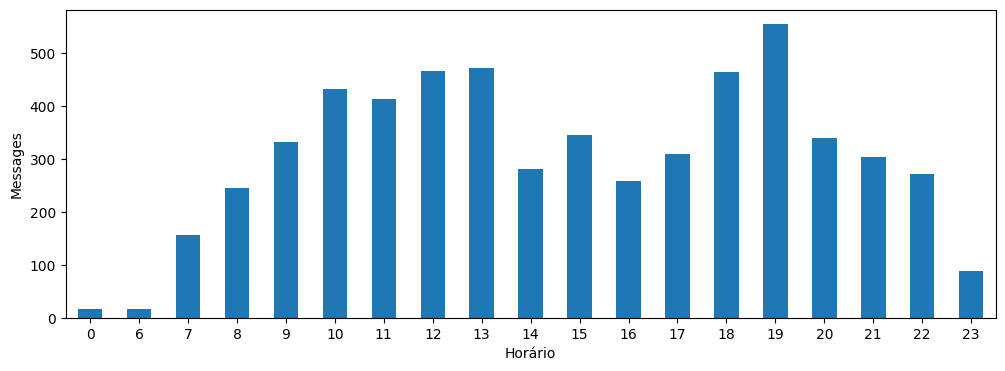

In [101]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby([df["date"].dt.hour])["text"].count().plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Horário");
plt.ylabel("Messages");

In [118]:
df['time_diff'] = df['date'].diff()
df['time_diff'] = df['time_diff'].fillna(pd.Timedelta(seconds=0))
df

,date,name,text,month,time_diff
0,2023-01-11 13:59:00,Roberto Rosa,localização: https://maps.google.com/?q=,1,0 days 00:00:00
1,2023-01-30 10:38:00,Roberto Rosa,4504399 protocolo,1,18 days 20:39:00
2,2023-01-30 10:40:00,Roberto Rosa,156@osasco.sp.gov.br,1,0 days 00:02:00
3,2023-01-31 00:22:00,Roberto Rosa,Confira Chales Bem me quer na Booking.com! ht...,1,0 days 13:42:00
4,2023-01-31 00:26:00,Roberto Rosa,Confira Casa Bambu Cunha na Booking.com! http...,1,0 days 00:04:00
...,...,...,...,...,...
5785,2024-01-23 06:48:00,Camila[Namo],Bom dia,1,0 days 00:13:00
5786,2024-01-23 06:48:00,Camila[Namo],Caiu da cama foi??,1,0 days 00:00:00
5787,2024-01-23 07:10:00,Roberto Rosa,Foi,1,0 days 00:22:00
5788,2024-01-23 07:10:00,Roberto Rosa,Hoje te obra no AP,1,0 days 00:00:00


In [121]:
df['time_diff'].max(), df['time_diff'].mean()

(Timedelta('18 days 20:39:00'), Timedelta('0 days 01:33:41.461139896'))

In [35]:
def get_words(df: pd.DataFrame, column: str) -> "list[str]":
    words = df[column].str.lower().str.translate(str.maketrans('', '', string.punctuation)).str.cat(sep=' ')
    tokens = nltk.tokenize.word_tokenize(words)
    stopwords_portugues = list(set(stopwords.words("portuguese")))
    
    return [word for word in tokens if word not in stopwords_portugues] 

In [37]:
def get_freq(df: pd.DataFrame, column: str) -> pd.DataFrame:
    return pd.DataFrame(nltk.FreqDist(get_words(df, column)).most_common(10), columns=['text', 'freq'])

In [53]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('portuguese'))
logistic_regression=LogisticRegression()

In [31]:
def load_dabase_traning():
    """
        load database to training
        return [train_x, train_y, test_x, test_y]
    """
    bss = BaseSentimentService.get_instance()
    df = pd.DataFrame.from_records(bss.get_collection().find())
    train, test = train_test_split(df, test_size=0.33, random_state=42)
    train_x, train_y = train['text'], train['sentiment']
    test_x, test_y = test['text'], test['sentiment']

    return [train_x, train_y, test_x, test_y]

In [29]:
def create_vectorizer_model(train_x, test_x):
    """
        Create new model tfid vectorizer
        return [train_x_vector test_x_vector]
    """
    train_x_vector = tfidf.fit_transform(train_x)
    test_x_vector = tfidf.transform(test_x)

    return [train_x_vector, test_x_vector]

In [54]:
train_x, train_y, test_x, test_y = load_dabase_traning()
train_x_vector, test_x_vector = create_vectorizer_model(train_x, test_x)

logistic_regression.fit(train_x_vector, train_y)

2024-01-26 14:55:31,353 INFO root MainThread : BaseSentimentService: started: get self collection


LogisticRegression()

In [60]:
input_text = tfidf.transform(get_words(df, 'text'))
predictions = dict(
            predict=logistic_regression.predict(input_text)[0],
            score_positive=logistic_regression.predict_proba(input_text)[0][1],
            score_negative=logistic_regression.predict_proba(input_text)[0][0])

In [128]:
agents = df['name'].drop_duplicates().values
users = []

for name in agents:
    user = User()
    query = f"name == '{str(name)}' "
    
    total_questions = df.query(query)[df.query(query)['text'].map(lambda x: str(x).endswith('?'))].shape[0]
    input_text = tfidf.transform(get_words(df.query(query), 'text'))

    proba = dict(
            predict=logistic_regression.predict(input_text)[0],
            score_positive=logistic_regression.predict_proba(input_text)[0][1],
            score_negative=logistic_regression.predict_proba(input_text)[0][0])
    
    users.append(vars(
        User()
        .set_name(name)
        .set_total_questions(total_questions)
        .set_total_messages(df.query(query).shape[0])
        .set_words_freq(get_freq(df.query(query), 'text').to_json(orient='records'))
        .set_prediction(proba.get('predict'))
        .set_score_positive(proba.get('score_positive'))
        .set_score_negative(proba.get('score_negative'))
    ))

In [130]:
vars(Conversation()
     .set_users(users)
     .set_total_messages(df.shape[0])
     .set_total_agents(len(agents))
     .set_words_freq(get_freq(df, 'text').to_json(orient='records'))
     .set_monthly(df.groupby(pd.Grouper(key='date', freq='M')).count().reset_index().to_json(orient='records'))
     .set_prediction(predictions.get('predict'))
     .set_score_positive(predictions.get('score_positive'))
     .set_score_negative(predictions.get('score_negative'))
     .set_mean_time_wait(df['time_diff'].mean()))

{'users': [{'name': 'Roberto Rosa',
   'total_questions': 321,
   'total_message': 3243,
   'words_freq': '[{"text":"t\\u00e1","freq":154},{"text":"vc","freq":145},{"text":"sim","freq":138},{"text":"pra","freq":137},{"text":"vou","freq":108},{"text":"bom","freq":106},{"text":"dia","freq":102},{"text":"casa","freq":95},{"text":"\\ud83d\\udc40","freq":84},{"text":"t\\u00f4","freq":78}]',
   'prediction': 'negative',
   'score_positive': 0.48451167974739223,
   'score_negative': 0.5154883202526077},
  {'name': 'Camila[Namo]',
   'total_questions': 839,
   'total_message': 2547,
   'words_freq': '[{"text":"vc","freq":337},{"text":"t\\u00e1","freq":202},{"text":"pra","freq":183},{"text":"bom","freq":119},{"text":"t\\u00f4","freq":101},{"text":"vai","freq":98},{"text":"a\\u00ed","freq":94},{"text":"dia","freq":90},{"text":"pq","freq":82},{"text":"vou","freq":75}]',
   'prediction': 'negative',
   'score_positive': 0.4094844226858984,
   'score_negative': 0.5905155773141015}],
 'total_message